# Chapter 8: Resampling and simulation

In [21]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, scoreatpercentile

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
# import NHANES package
base = importr('NHANES')

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])

 
NHANES = NHANES.drop_duplicates(subset='ID')
NHANES_adult = NHANES.dropna(subset=['Height']).query('Age > 17')

rng = np.random.RandomState(12345)


## Figure 8.1

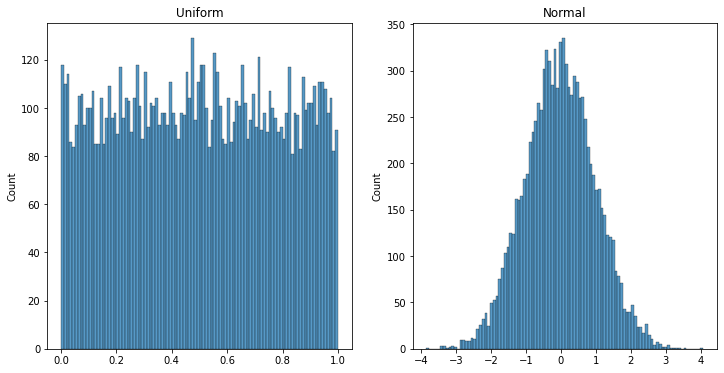

In [10]:
nsamps = 10000

fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.histplot(rng.uniform(size=nsamps), bins=100, ax=ax[0])
ax[0].set_title('Uniform')

sns.histplot(rng.randn(nsamps), bins=100, ax=ax[1])
_ = ax[1].set_title('Normal')

## Figure 8.2

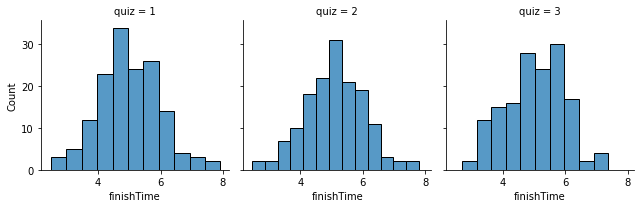

In [18]:
finishTimeDf = pd.DataFrame({
    'finishTime': rng.normal(5, 1, 3*150),
    'quiz': np.kron([1, 2, 3], np.ones(150, dtype='int'))})

g = sns.FacetGrid(finishTimeDf, col="quiz")
g.map_dataframe(sns.histplot, x="finishTime")

## Figure 8.3

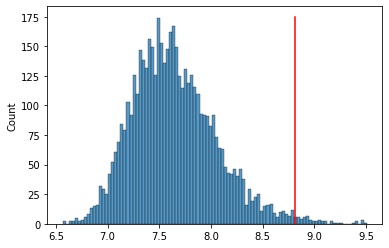

In [28]:
nRuns = 5000
sampSize = 150

def sampleMax(sampSize = 150):
    samp = rng.normal(5, 1, sampSize)
    return samp.max()

maxTime = [sampleMax() for i in range(nRuns)]
cutoff = scoreatpercentile(maxTime, 99)

sns.histplot(maxTime, bins=100)
plt.plot([cutoff, cutoff], [0, 175], color='red')

## Figure 8.4

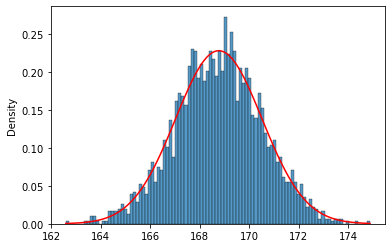

In [41]:
nRuns = 2500
sampleSize = 32

heightSample = NHANES_adult.dropna(subset=['Height']).query('Height > 0').sample(sampleSize)

def bootMeanHeight(df):
    bootSample = df.sample(df.shape[0], replace=True)
    return bootSample.Height.mean()

bootMeans = [bootMeanHeight(heightSample) for i in range(nRuns)]

SEM_standard = heightSample.Height.std() / np.sqrt(sampleSize)
SEM_bootstrap = np.std(bootMeans)

sns.histplot(bootMeans, bins=100, stat='density')
x = np.arange(np.min(bootMeans), np.max(bootMeans), 0.1)
y = norm.pdf(x, loc=np.mean(bootMeans), scale=np.std(bootMeans))
_ = plt.plot(x,y, color='red')